## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
device = 'cuda:0'

In [3]:
torch.cuda.is_available()

True

## Data

In [3]:
# path where data will be stored
DATA_PATH = r'D:\Users\amira\Documents\projects\face-recognition\data'

In [4]:
IMG_SIZE = 112

transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

Dataset returns two photos and label:
- 1 - same person on both photos
- 0 - different persons

In [5]:
lfw_pairs_train = torchvision.datasets.LFWPairs(root = DATA_PATH, split = 'train', image_set = 'funneled', transform = transform, download = True)
lfw_pairs_test = torchvision.datasets.LFWPairs(root = DATA_PATH, split = 'test', image_set = 'funneled', transform = transform, download = True)

Files already downloaded and verified
Files already downloaded and verified


## Look at data

In [39]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

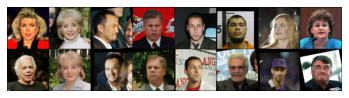

[0 1 1 1 1 0 0 0]


In [7]:
vis_dataloader = DataLoader(lfw_pairs_train,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

## Contrastive Loss

In [6]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2) +
                                    (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

## Siamese Network (IMG_SIZE = 224)

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=4,stride=2), # 96*111*111
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # 96*55*55
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1), # 256*51*51
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # 256*25*25

            nn.Conv2d(256, 384, kernel_size=3,stride=1), # 384*23*23
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2), # 384*11*11

            nn.Conv2d(384, 500, kernel_size=3,stride=2), # 500*5*5
            nn.ReLU(inplace=True),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(12500, 4000),
            nn.ReLU(inplace=True),

            nn.Linear(4000, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        #print(output.shape)
        output = output.view(output.size()[0], -1)
        #print(output.shape)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [12]:
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        batch_size=32)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

Epoch number 0
 Current loss 2.1243276596069336

Epoch number 0
 Current loss 2.3351473808288574

Epoch number 0
 Current loss 1.518886685371399

Epoch number 0
 Current loss 1.3336660861968994

Epoch number 0
 Current loss 1.2687360048294067

Epoch number 0
 Current loss 1.2533515691757202

Epoch number 0
 Current loss 1.0905325412750244

Epoch number 1
 Current loss 1.6652213335037231

Epoch number 1
 Current loss 1.0368293523788452

Epoch number 1
 Current loss 1.2082030773162842

Epoch number 1
 Current loss 1.265764594078064

Epoch number 1
 Current loss 1.2743043899536133

Epoch number 1
 Current loss 1.4914965629577637

Epoch number 1
 Current loss 1.6313965320587158

Epoch number 2
 Current loss 1.0692137479782104

Epoch number 2
 Current loss 1.2266921997070312

Epoch number 2
 Current loss 1.2604899406433105

Epoch number 2
 Current loss 1.1798871755599976

Epoch number 2
 Current loss 1.389216661453247

Epoch number 2
 Current loss 1.2632824182510376

Epoch number 2
 Current

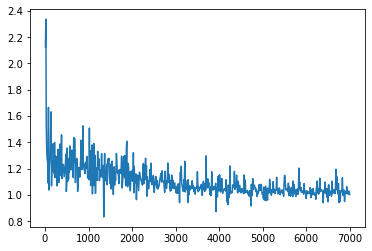

In [13]:
NUM_EPOCHS = 100

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(NUM_EPOCHS):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        
        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

### Validation

In [ ]:
test_dataloader = DataLoader(lfw_pairs_test, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)

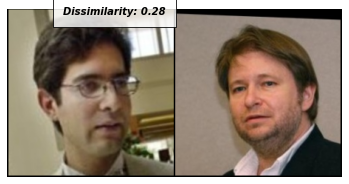

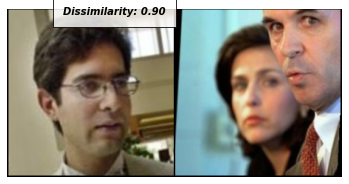

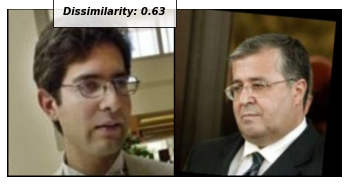

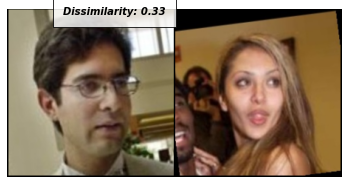

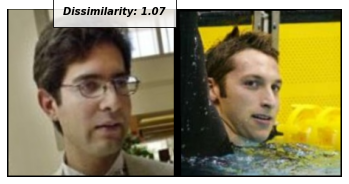

In [15]:
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## ResNet50 as Base Net

In [7]:
class SiameseNetwork(nn.Module):    
    def __init__(self, base_net, emb_dim, feat_dim=None):
        super(SiameseNetwork, self).__init__()
        self.base_net = base_net
        
        try:
            in_dim = base_net.fc.out_features
        except NameError as e:
            if feat_dim is not None:
                in_dim = feat_dim
            else:
                raise Exception("Neither does the base_net hase fc layer nor in_dim is specificed")
        self.dense = nn.Linear(in_dim, emb_dim)
        

    def forward_once(self, x):
        output = self.base_net(x)
        output = self.dense(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)

        output2 = self.forward_once(input2)

        return output1, output2


### Training

In [ ]:
from torchvision.models import resnet50

resnet_50 = resnet50(pretrained=True)

In [11]:
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        batch_size=16)

net = SiameseNetwork(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.005)

Epoch number 0
 Current loss 79.4833984375

Epoch number 0
 Current loss 4.737780570983887

Epoch number 0
 Current loss 1.7115788459777832

Epoch number 0
 Current loss 1.221269965171814

Epoch number 0
 Current loss 1.2159979343414307

Epoch number 0
 Current loss 1.0310819149017334

Epoch number 0
 Current loss 1.2225972414016724

Epoch number 0
 Current loss 1.2901675701141357

Epoch number 0
 Current loss 1.2556238174438477

Epoch number 0
 Current loss 1.4255344867706299

Epoch number 0
 Current loss 1.0767418146133423

Epoch number 0
 Current loss 1.1498489379882812

Epoch number 0
 Current loss 1.3342375755310059

Epoch number 0
 Current loss 1.0600889921188354

Epoch number 1
 Current loss 1.2803270816802979

Epoch number 1
 Current loss 1.1260855197906494

Epoch number 1
 Current loss 1.196163296699524

Epoch number 1
 Current loss 0.8681753873825073

Epoch number 1
 Current loss 1.126320719718933

Epoch number 1
 Current loss 1.2352434396743774

Epoch number 1
 Current loss 

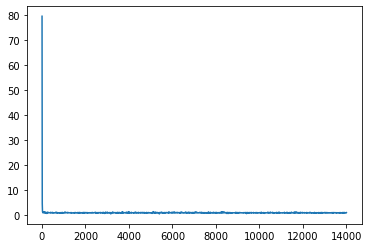

In [12]:
NUM_EPOCHS = 100

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(NUM_EPOCHS):
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        
        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [ ]:
SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'

In [18]:
torch.save(net.state_dict(), os.path.join(SAVE_PATH, 'resnet50_100'))

### Validation

In [ ]:
net = SiameseNetwork(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
net.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_100')))
net.eval()

In [65]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

In [66]:
lfw_pairs_test = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=transform, image_set = 'funneled', download = True)

Files already downloaded and verified


In [67]:
test_dataloader = DataLoader(lfw_pairs_test, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


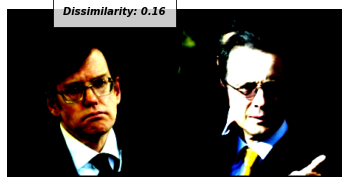

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


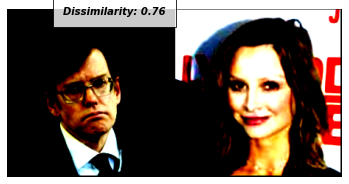

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


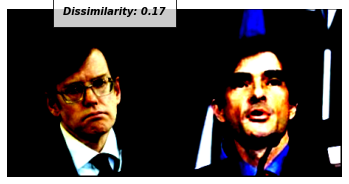

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


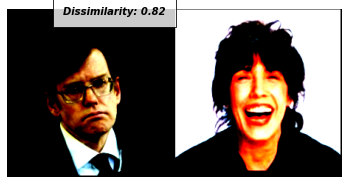

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


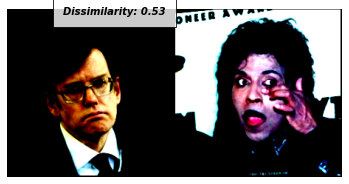

In [21]:
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

### Extra Training

In [10]:
import sys

import random
import numpy as np
import torch

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
from torch.optim import lr_scheduler
import torch.nn as nn
from tqdm import tqdm


In [11]:
batch_size = 32
lr = 1e-2
n_epochs = 20
log_interval = 50

In [91]:
train_dataloader = DataLoader(lfw_pairs_train,
                        shuffle=True,
                        batch_size=batch_size)

test_dataloader = DataLoader(lfw_pairs_test,
                        shuffle=True,
                        batch_size=batch_size)

In [13]:
from torchvision.models import resnet50

SAVE_PATH= 'D:/Users/amira/Documents/projects/face-recognition/models'
exp_name = "siamese_resnet_50"
resnet_50 = resnet50(pretrained=True)
model = SiameseNetwork(base_net=resnet_50, emb_dim=128, feat_dim=512).cuda()
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'resnet50_100')))

In [15]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1)

In [18]:
def train_epoch(train_dataloader,model,criterion,optimizer,epoch):
    
    model.train()
    total_loss = 0
    iteration_number= 0
    
    for batch_idx, (img0, img1, label) in enumerate(train_dataloader, 0):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output0, output1 = model(img0, img1)
        loss = criterion(output0, output1, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Every 20 batches print out the loss
        if batch_idx % 20 == 0 :
            print(
            "Epoch {} Iteration {}: Loss = {}".format(
                epoch, batch_idx, loss
            ))
            iteration_number += 20

        
    total_loss = total_loss/(1+batch_idx)
    
    return total_loss


def validate_epoch(test_dataloader,model,criterion):

    model.eval()
    
    with torch.no_grad():
        model.eval()
        val_loss = 0
        
        for batch_idx, (img0, img1, label) in enumerate(test_dataloader, 0):
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            output0, output1 = model(img0, img1)
                
            loss = criterion(output0,output1,label)

            val_loss += loss.item()

    val_loss = val_loss/(1+batch_idx)
        
    return val_loss


def save_model(model,model_name, save_path,best_loss):
    #name = "best_{}".format(model_name) + "_{}.pth".format(best_loss, ".3f")
    experiment_name = os.path.join(save_path,  "best_{}.pth".format(model_name))
    torch.save(model.state_dict(),experiment_name)

In [19]:
train_losses = []
val_losses = []
best_loss = np.inf

for epoch in range(n_epochs):
        
    learning_rate = scheduler.get_lr()
    train_loss = train_epoch(train_dataloader,model,criterion,optimizer,epoch)
    val_loss = validate_epoch(test_dataloader,model,criterion)
    scheduler.step()
    
    if val_loss<best_loss:
        best_loss =  val_loss
        save_model(model,exp_name,SAVE_PATH,best_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print("Epoch Number : {}".format(epoch))
    print("---------------------------------------------------------------")
    print("    Train Loss :{}  , Val_Loss : {} , Learning Rate: {}".format(val_loss,val_loss,learning_rate))

D:\Users\amira\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 0 Iteration 0: Loss = 1.1696357727050781
Epoch 0 Iteration 20: Loss = 1.0076011419296265
Epoch 0 Iteration 40: Loss = 1.0822193622589111
Epoch 0 Iteration 60: Loss = 1.0866312980651855
Epoch Number : 0
---------------------------------------------------------------
    Train Loss :1.065034555271268  , Val_Loss : 1.065034555271268 , Learning Rate: [0.01]


Epoch 1 Iteration 0: Loss = 1.035164475440979
Epoch 1 Iteration 20: Loss = 1.0694067478179932
Epoch 1 Iteration 40: Loss = 0.9765315055847168
Epoch 1 Iteration 60: Loss = 1.0781304836273193
Epoch Number : 1
---------------------------------------------------------------
    Train Loss :1.0764615833759308  , Val_Loss : 1.0764615833759308 , Learning Rate: [0.01]


Epoch 2 Iteration 0: Loss = 1.10558021068573
Epoch 2 Iteration 20: Loss = 1.1092097759246826
Epoch 2 Iteration 40: Loss = 1.025700330734253
Epoch 2 Iteration 60: Loss = 0.9400256276130676
Epoch Number : 2
---------------------------------------------------------------
  

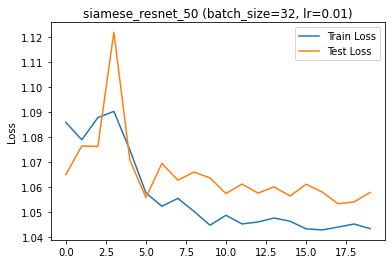

In [35]:
plt.title(exp_name + " (batch_size={}, lr={})".format(batch_size, lr))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [47]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])


In [48]:
lfw_pairs_eval = torchvision.datasets.LFWPairs(root = r'D:\Users\amira\Documents\projects\face-recognition\data', split = 'test', transform=transform, image_set = 'funneled', download = True)
eval_dataloader = DataLoader(lfw_pairs_eval, batch_size=1, shuffle=True)
dataiter = iter(eval_dataloader)

Files already downloaded and verified


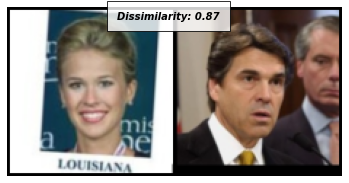

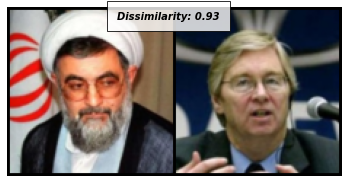

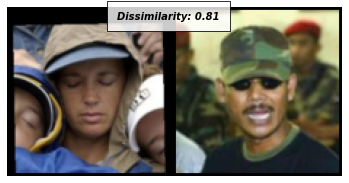

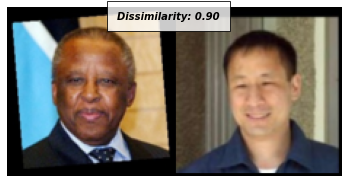

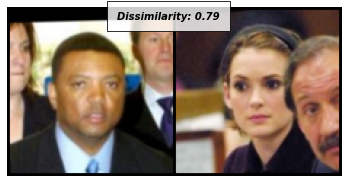

In [50]:
for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, _, _ = next(dataiter)
    _, x1, _ = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')